# Insertion library

# Clustering analysis

In [1]:
# default modules
import sys
import math
import random
import pickle

In [2]:
# external modules
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
# increase figure resolution
plt.rcParams['figure.dpi'] = 100

In [4]:
# custom modules
import analysis_final as analysis
from SliderClass_final import Slider
import graph_final as graph

In [5]:
# working directory
path = "/home/spark159/../../media/spark159/sw/slide_seq_data(2021.07.14)/"

In [6]:
# basic parameters
tlen = 225 # sliding DNA template length
NCPlen = 147 # nucleosomal DNA length

In [7]:
# load WT 601 sliding data
WT_slider1 = pickle.load(open(path+'601_0min'+'.pickle'))['601']
WT_slider2 = pickle.load(open(path+'601_5min'+'.pickle'))['601']

In [8]:
# WT 601 template sequence
WTseq = WT_slider1.seq

In [9]:
# load insertion library data
insertion_sliders1 = pickle.load(open(path+'IDlib_bubble_0min_1rep'+'.pickle'))
insertion_sliders2 = pickle.load(open(path+'IDlib_bubble_5min_1rep'+'.pickle'))

In [10]:
# set target ids
common_ids = list(set(insertion_sliders1.keys()) & set(insertion_sliders2.keys()))
target_ids = []
for id in common_ids:
    loc, mtype, nts = id.split('-')
    if mtype != 'I':
        continue
    target_ids.append(id)
target_ids = sorted(target_ids, cmp=analysis.wid_cmp_len)

In [11]:
# get nucleosome positioning signal
id_psig1, id_psig2 = {}, {}
for id in target_ids:
    psig1 = insertion_sliders1[id].get_psig()
    psig2 = insertion_sliders2[id].get_psig()
    id_psig1[id] = psig1
    id_psig2[id] = psig2

In [12]:
# get pair-wise distance1 (slow)
fname = path+'insertionlib_JS_dist1'+'.pickle'
try:
    id1_id2_dist1 = pickle.load(open(fname))
except:
    id1_id2_dist1 = analysis.get_pair_dist(id_psig1, metric='JS')
    pickle.dump(id1_id2_dist1, open(fname, 'wb'))  

In [13]:
# get pair-wise distance2 (slow)
fname = path+'insertionlib_JS_dist2'+'.pickle'
try:
    id1_id2_dist2 = pickle.load(open(fname))
except:
    id1_id2_dist2 = analysis.get_pair_dist(id_psig2, metric='JS')
    pickle.dump(id1_id2_dist2, open(fname, 'wb'))  

In [14]:
# get pair-wise similarity score
id1_id2_score1 = analysis.get_pair_score(id1_id2_dist1, scale=10)
id1_id2_score2 = analysis.get_pair_score(id1_id2_dist2, scale=10)

In [15]:
# spectral clustering
id_cID1, cID_ids1 = analysis.Spectral_clustering(id1_id2_score1, cnum=3)
id_cID2, cID_ids2 = analysis.Spectral_clustering(id1_id2_score2, cnum=4)

In [16]:
# change cluster ID in the order of the mean value of signal
def change_cID (id_slider, id_cID, cID_ids):
    cID_meanpos = {}
    for cID in cID_ids:
        temp = []
        for id in cID_ids[cID]:
            meanpos = id_slider[id].median_pos()
            temp.append(meanpos)
        cID_meanpos[cID] = np.mean(temp)

    cIDs = analysis.dict_sort(cID_meanpos)

    cID_newcID = {}
    for i in range(len(cIDs)):
        cID = cIDs[i]
        cID_newcID[cID] = i

    id_newcID = {}
    for id, cID in id_cID.items():
        id_newcID[id] = cID_newcID[cID]

    newcID_ids = {}
    for cID, id_list in cID_ids.items():
        newcID_ids[cID_newcID[cID]] = id_list
        
    return id_newcID, newcID_ids

In [17]:
id_cID1, cID_ids1 = change_cID (insertion_sliders1, id_cID1, cID_ids1)
id_cID2, cID_ids2 = change_cID (insertion_sliders2, id_cID2, cID_ids2)

In [18]:
# color for each cluster
color_list = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan",
             "blue", "lime"]*2

In [19]:
# Silhouette score
id_s1 = analysis.Silhouette (id_cID1, cID_ids1, id1_id2_dist1)
id_s2 = analysis.Silhouette (id_cID2, cID_ids2, id1_id2_dist2)

In [20]:
# Silhouette plot
def Silhouette_plot (id_s, cID_ids, color_list):
    fig = plt.figure()
    i = 0
    for cID in cID_ids.keys():
        color = color_list[cID]
        s_id = sorted([(id_s[id], id) for id in cID_ids[cID]], cmp=analysis.tuple_cmp, reverse=True)
        X_list, Y_list = [], [] 
        for s, id in s_id:
            X_list.append(i)
            Y_list.append(s)
            i +=1
        plt.plot(X_list, Y_list, '.', color=color, label='Cluster #' + str(cID+1))
    plt.xlabel('seq ID')
    plt.ylabel('s-value')
    plt.title("Silhouette plot")
    plt.legend()
    plt.show()
    plt.close()

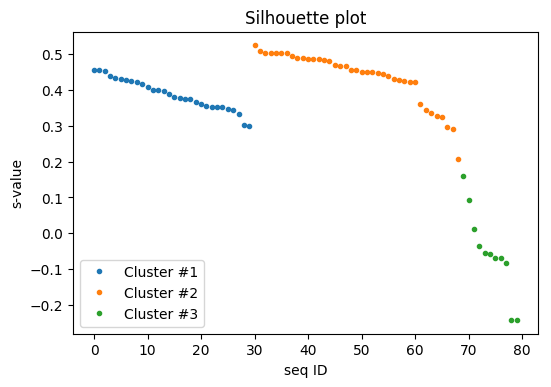

In [21]:
# Silhouette plot (before sliding)
Silhouette_plot(id_s1, cID_ids1, color_list)

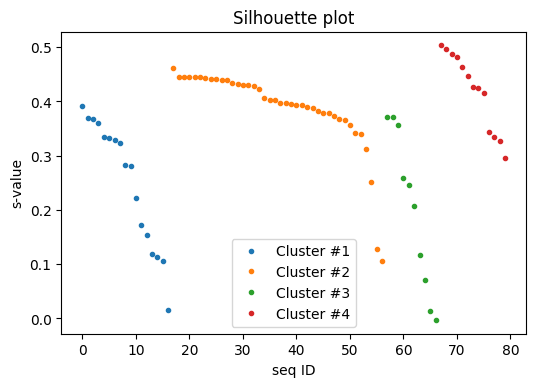

In [22]:
# Silhouette plot (after sliding)
Silhouette_plot(id_s2, cID_ids2, color_list)

In [23]:
# PCA analysis
id_pca1, pca_basis1, pca_var1 = analysis.PCA_analysis(id_psig1, stand_mean=True, stand_std=False, n_components=False)
id_pca2, pca_basis2, pca_var2 = analysis.PCA_analysis(id_psig2, stand_mean=True, stand_std=False, n_components=False)

In [24]:
# 2-d plot for data
def TwoD_plot(id_vec, cID_ids, color_list, title, xlabel, ylabel):
    fig = plt.figure()
    for cID in cID_ids.keys():
        color = color_list[cID]
        X_list, Y_list = [], []
        for id in cID_ids[cID]:
            X_list.append(id_vec[id][0])
            Y_list.append(id_vec[id][1])
        plt.plot(X_list, Y_list, '.', color=color, label='Cluster #' + str(cID+1))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    plt.close()

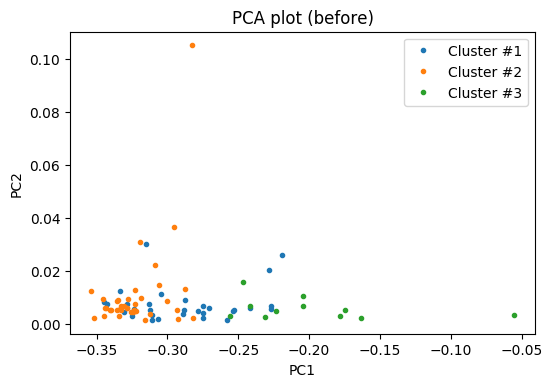

In [25]:
# PCA plot (before sliding)
TwoD_plot(id_pca1, cID_ids1, color_list, title='PCA plot (before)', xlabel='PC1', ylabel='PC2')

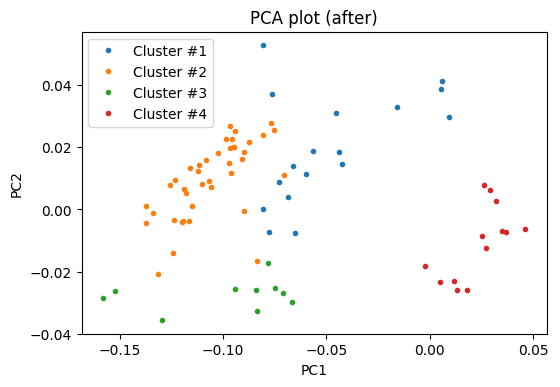

In [26]:
# PCA plot (after sliding)
TwoD_plot(id_pca2, cID_ids2, color_list, title='PCA plot (after)', xlabel='PC1', ylabel='PC2')

In [27]:
# tSNE analysis
id_tsne1 = analysis.tSNE_analysis (id1_id2_dist1, n_components=2, perp=60)
id_tsne2 = analysis.tSNE_analysis (id1_id2_dist2, n_components=2, perp=60)

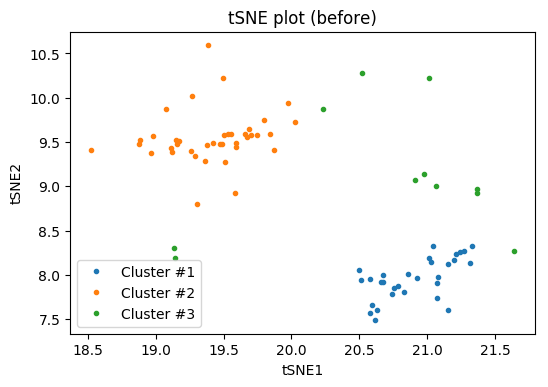

In [28]:
# PCA plot (before sliding)
TwoD_plot(id_tsne1, cID_ids1, color_list, title='tSNE plot (before)', xlabel='tSNE1', ylabel='tSNE2')

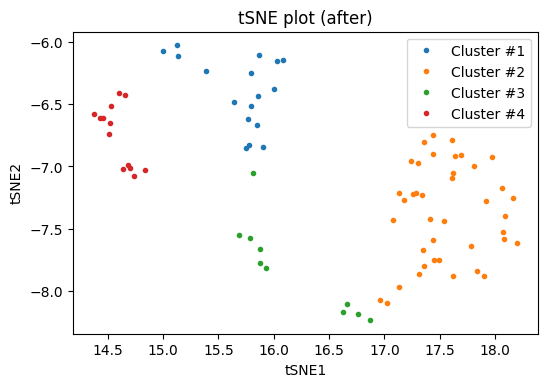

In [29]:
# PCA plot (after sliding)
TwoD_plot(id_tsne2, cID_ids2, color_list, title='tSNE plot (after)', xlabel='tSNE1', ylabel='tSNE2')

In [30]:
# plot similarity matrix
def plot_sim_matrix (id1_id2_score, cID_ids):
    new_ids = []
    for cID in sorted(cID_ids.keys()):
        temp = cID_ids[cID]
        random.shuffle(temp)
        new_ids += temp

    ids = id1_id2_score.keys()
    img = np.zeros((len(ids), len(ids)))
    img[:] = np.nan
    for i in range(len(new_ids)-1): 
        for j in range(i+1, len(new_ids)):
            id1, id2 = new_ids[i], new_ids[j]
            score = id1_id2_score[id1][id2]
            img[j][i] = score
            img[i][j] = score

    fig = plt.figure()
    plt.imshow(img, cmap="jet")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Similarity value', rotation=-90, va="bottom")
    plt.title("Similarity Matrix")
    plt.xlabel("seq ID")
    plt.ylabel("seq ID")
    plt.show()
    plt.close()

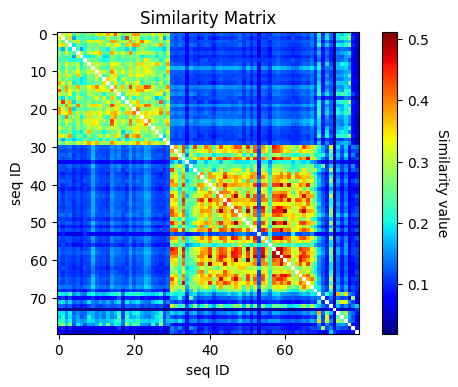

In [31]:
# plot similarity matrix (before)
plot_sim_matrix(id1_id2_score1, cID_ids1)

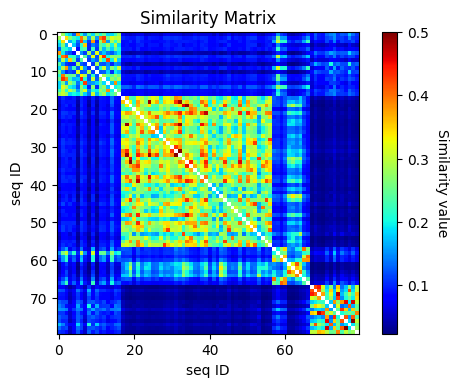

In [32]:
# plot similarity matrix (after)
plot_sim_matrix(id1_id2_score2, cID_ids2)


Cluster #1


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


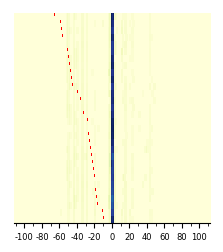


Cluster #2


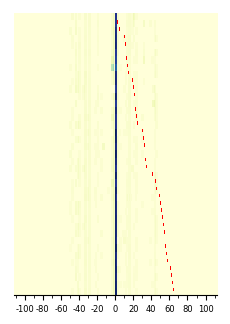


Cluster #3


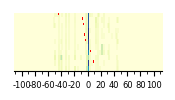

In [33]:
# plot heatmap for each cluster (before)
for cID in sorted(cID_ids1.keys()):
    print
    print "Cluster #%d" % (cID+1)
    ids = sorted(cID_ids1[cID], cmp=analysis.wid_cmp_len)
    graph.plot_map(insertion_sliders1, Slider.highlight_peaks, ids=ids, mark='wid', cmap='YlGnBu', thickness=[8,0,4],  xticks=[[i+tlen/2 for i in range(-100, 101, 20)], [str(i) for i in range(-100, 101, 20)]])


Cluster #1


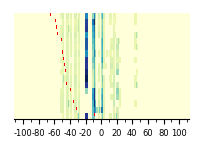


Cluster #2


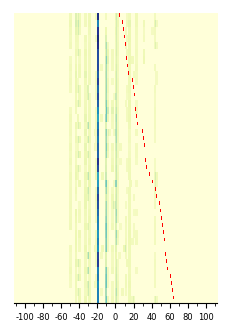


Cluster #3


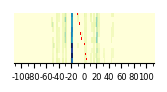


Cluster #4


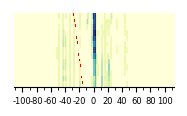

In [34]:
# plot heatmap for each cluster (after)
for cID in sorted(cID_ids2.keys()):
    print
    print "Cluster #%d" % (cID+1)
    ids = sorted(cID_ids2[cID], cmp=analysis.wid_cmp_ed)
    graph.plot_map(insertion_sliders2, Slider.highlight_peaks, ids=ids, mark='wid', cmap='YlGnBu', thickness=[8,0,4],  xticks=[[i+tlen/2 for i in range(-100, 101, 20)], [str(i) for i in range(-100, 101, 20)]])


Cluster #1


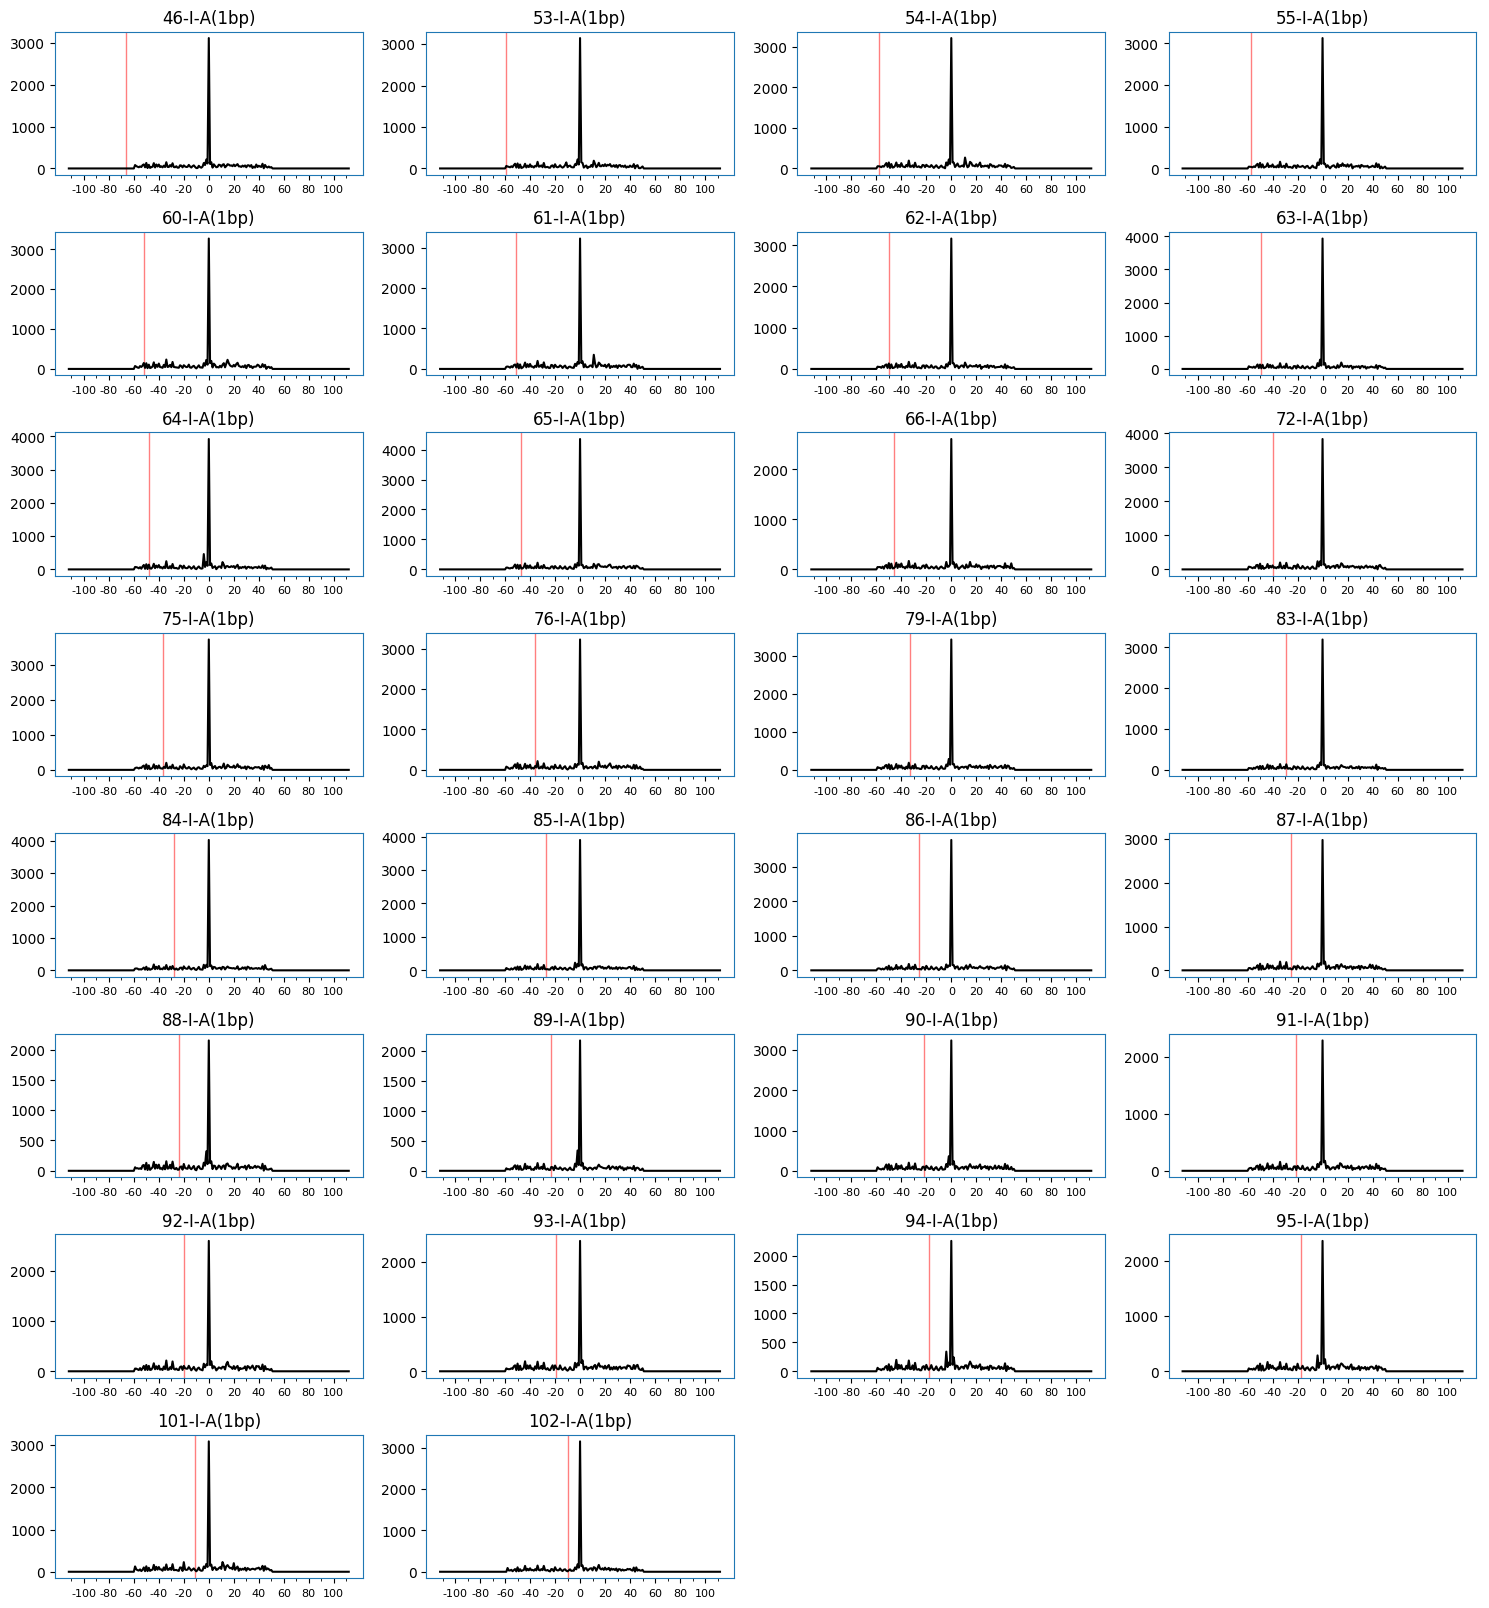


Cluster #2


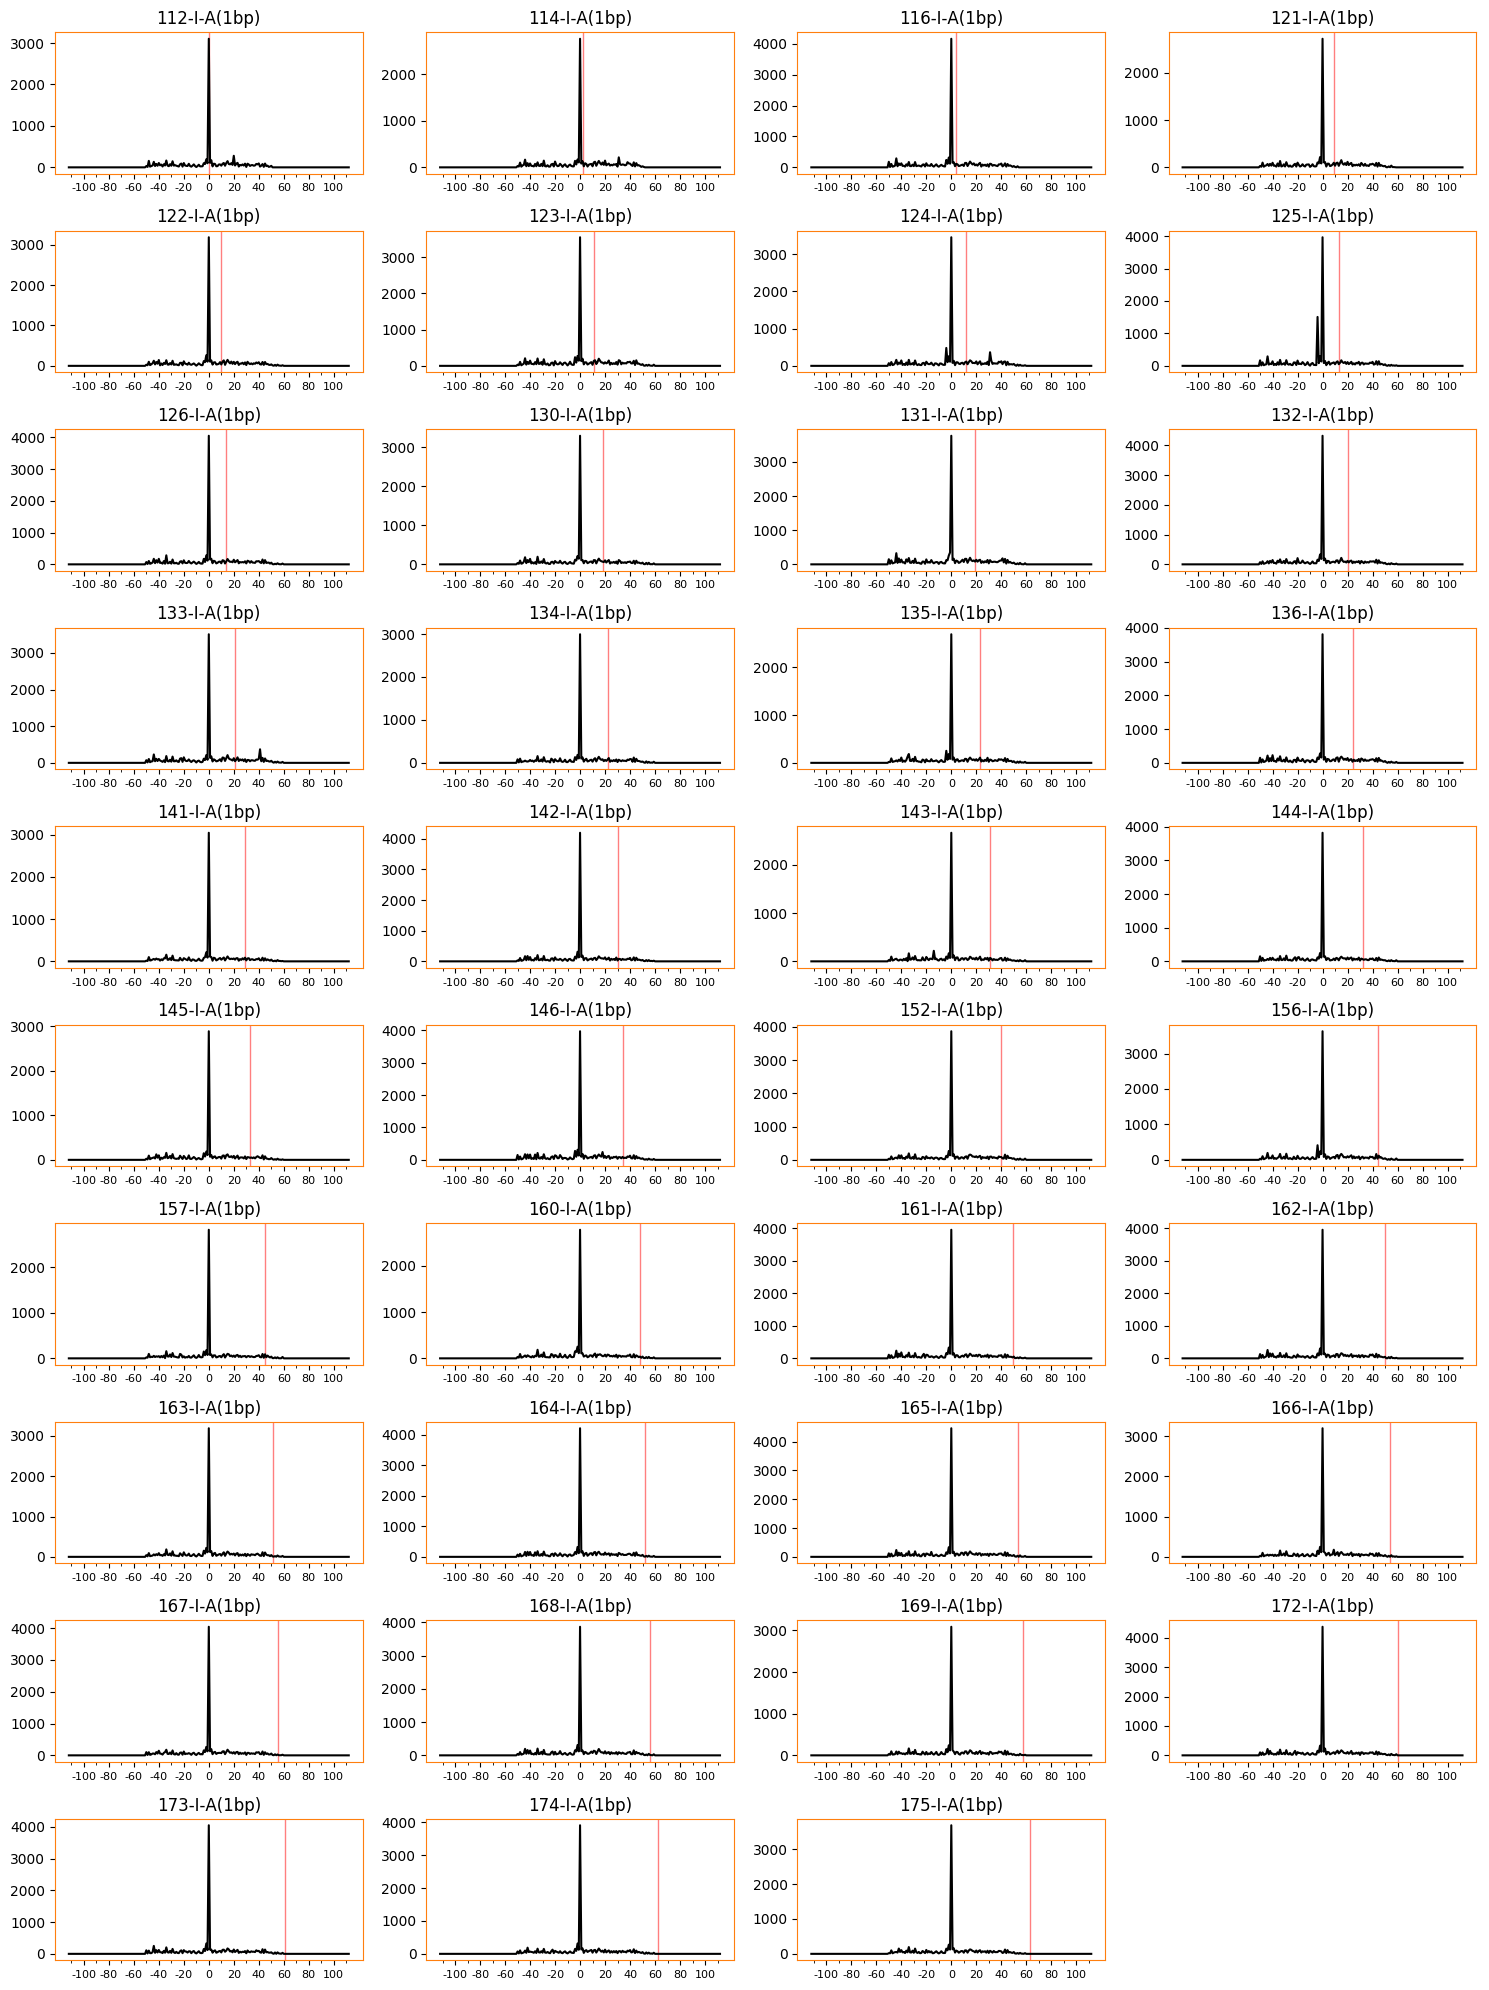


Cluster #3


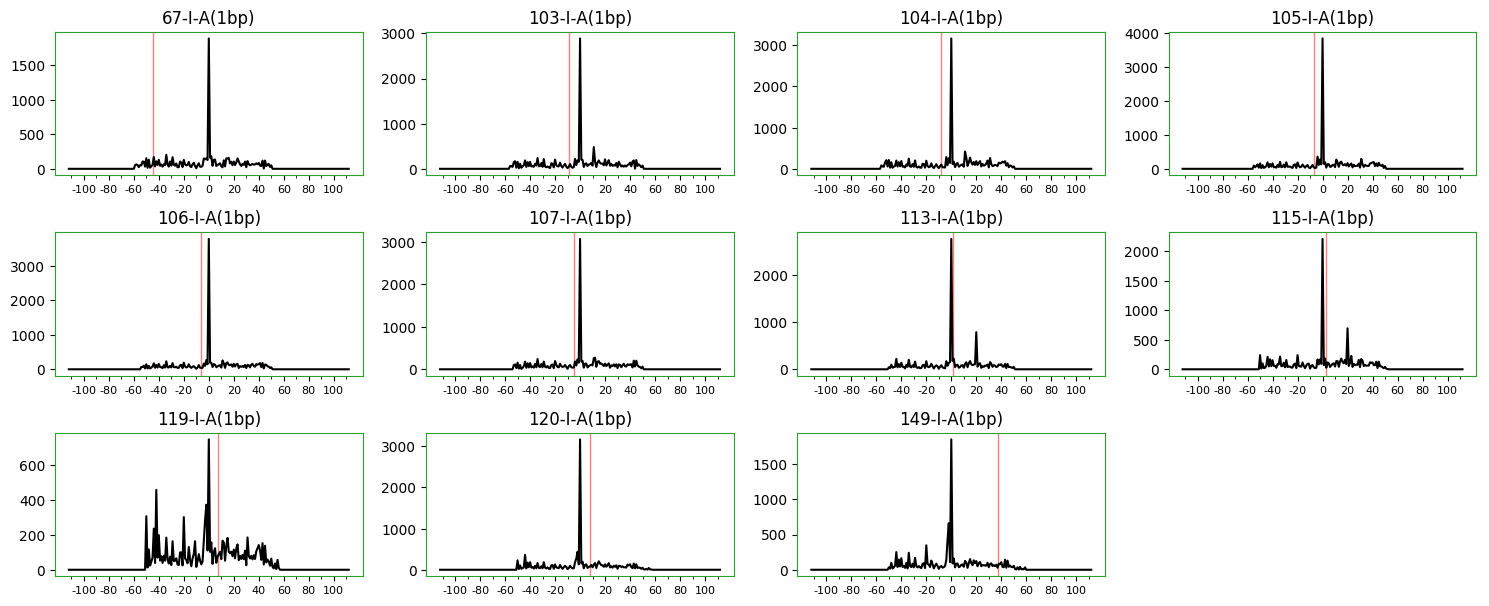

In [35]:
# plot positioning signals for each cluster (before)
for cID in sorted(cID_ids1.keys()):
    print
    print "Cluster #%d" % (cID+1)
    ids = sorted(cID_ids1[cID], cmp=analysis.wid_cmp_len)
    graph.plot_sig(insertion_sliders1, Slider.get_dyadmap, ids=ids, mark='wid', color='k', frame_color=color_list[cID],  xticks=[[i+tlen/2 for i in range(-100, 101, 20)], [str(i) for i in range(-100, 101, 20)]])


Cluster #1


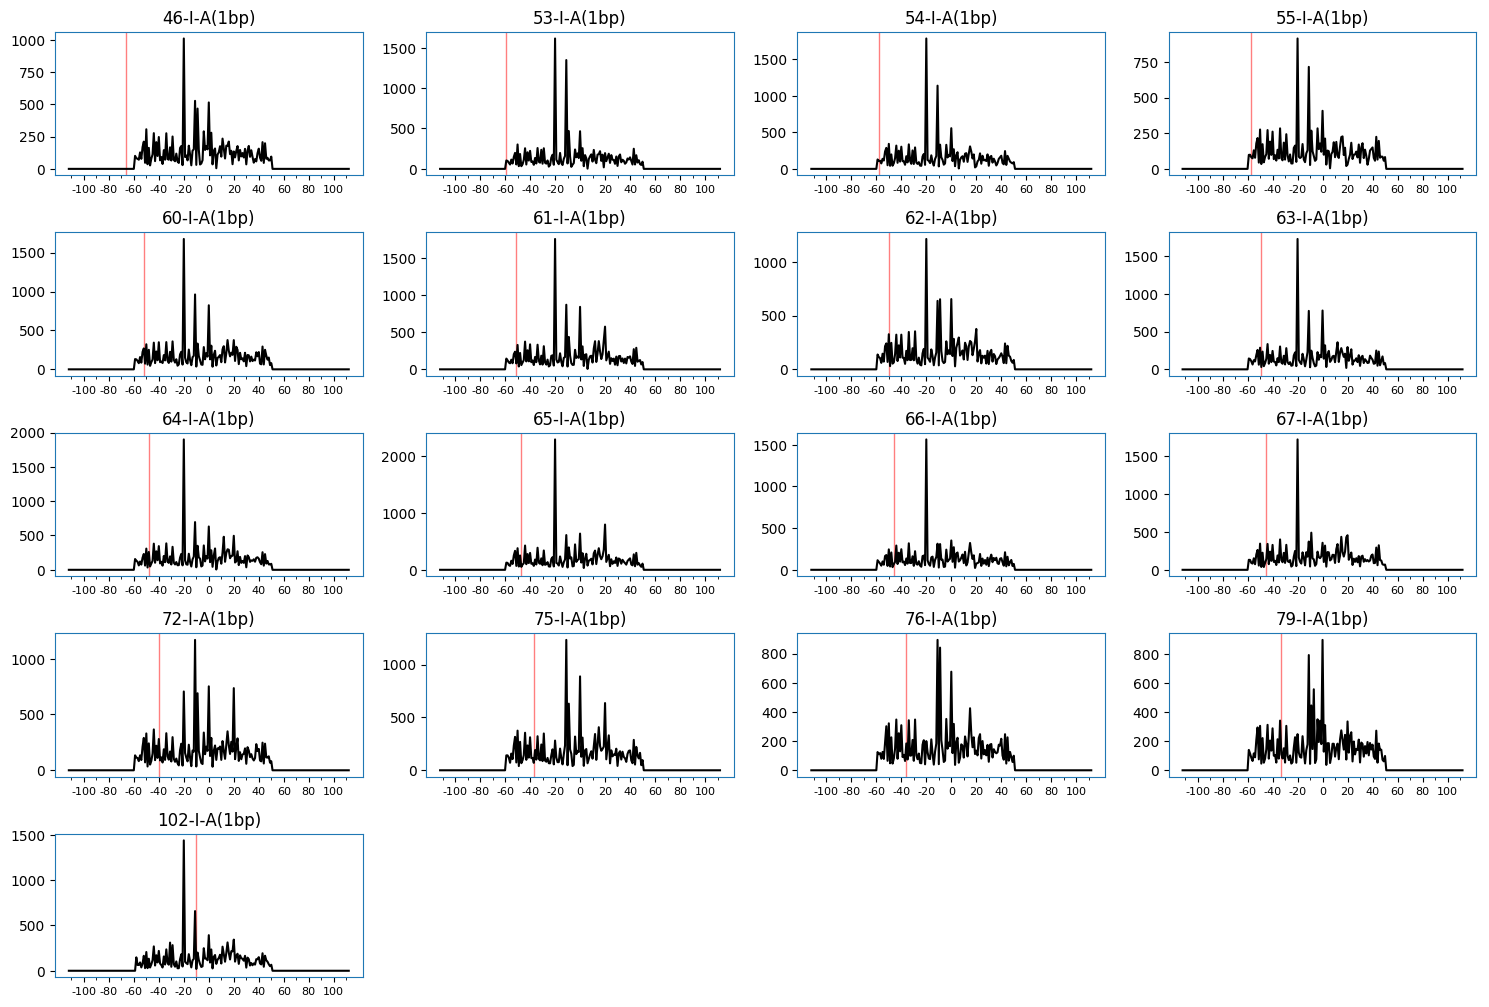


Cluster #2


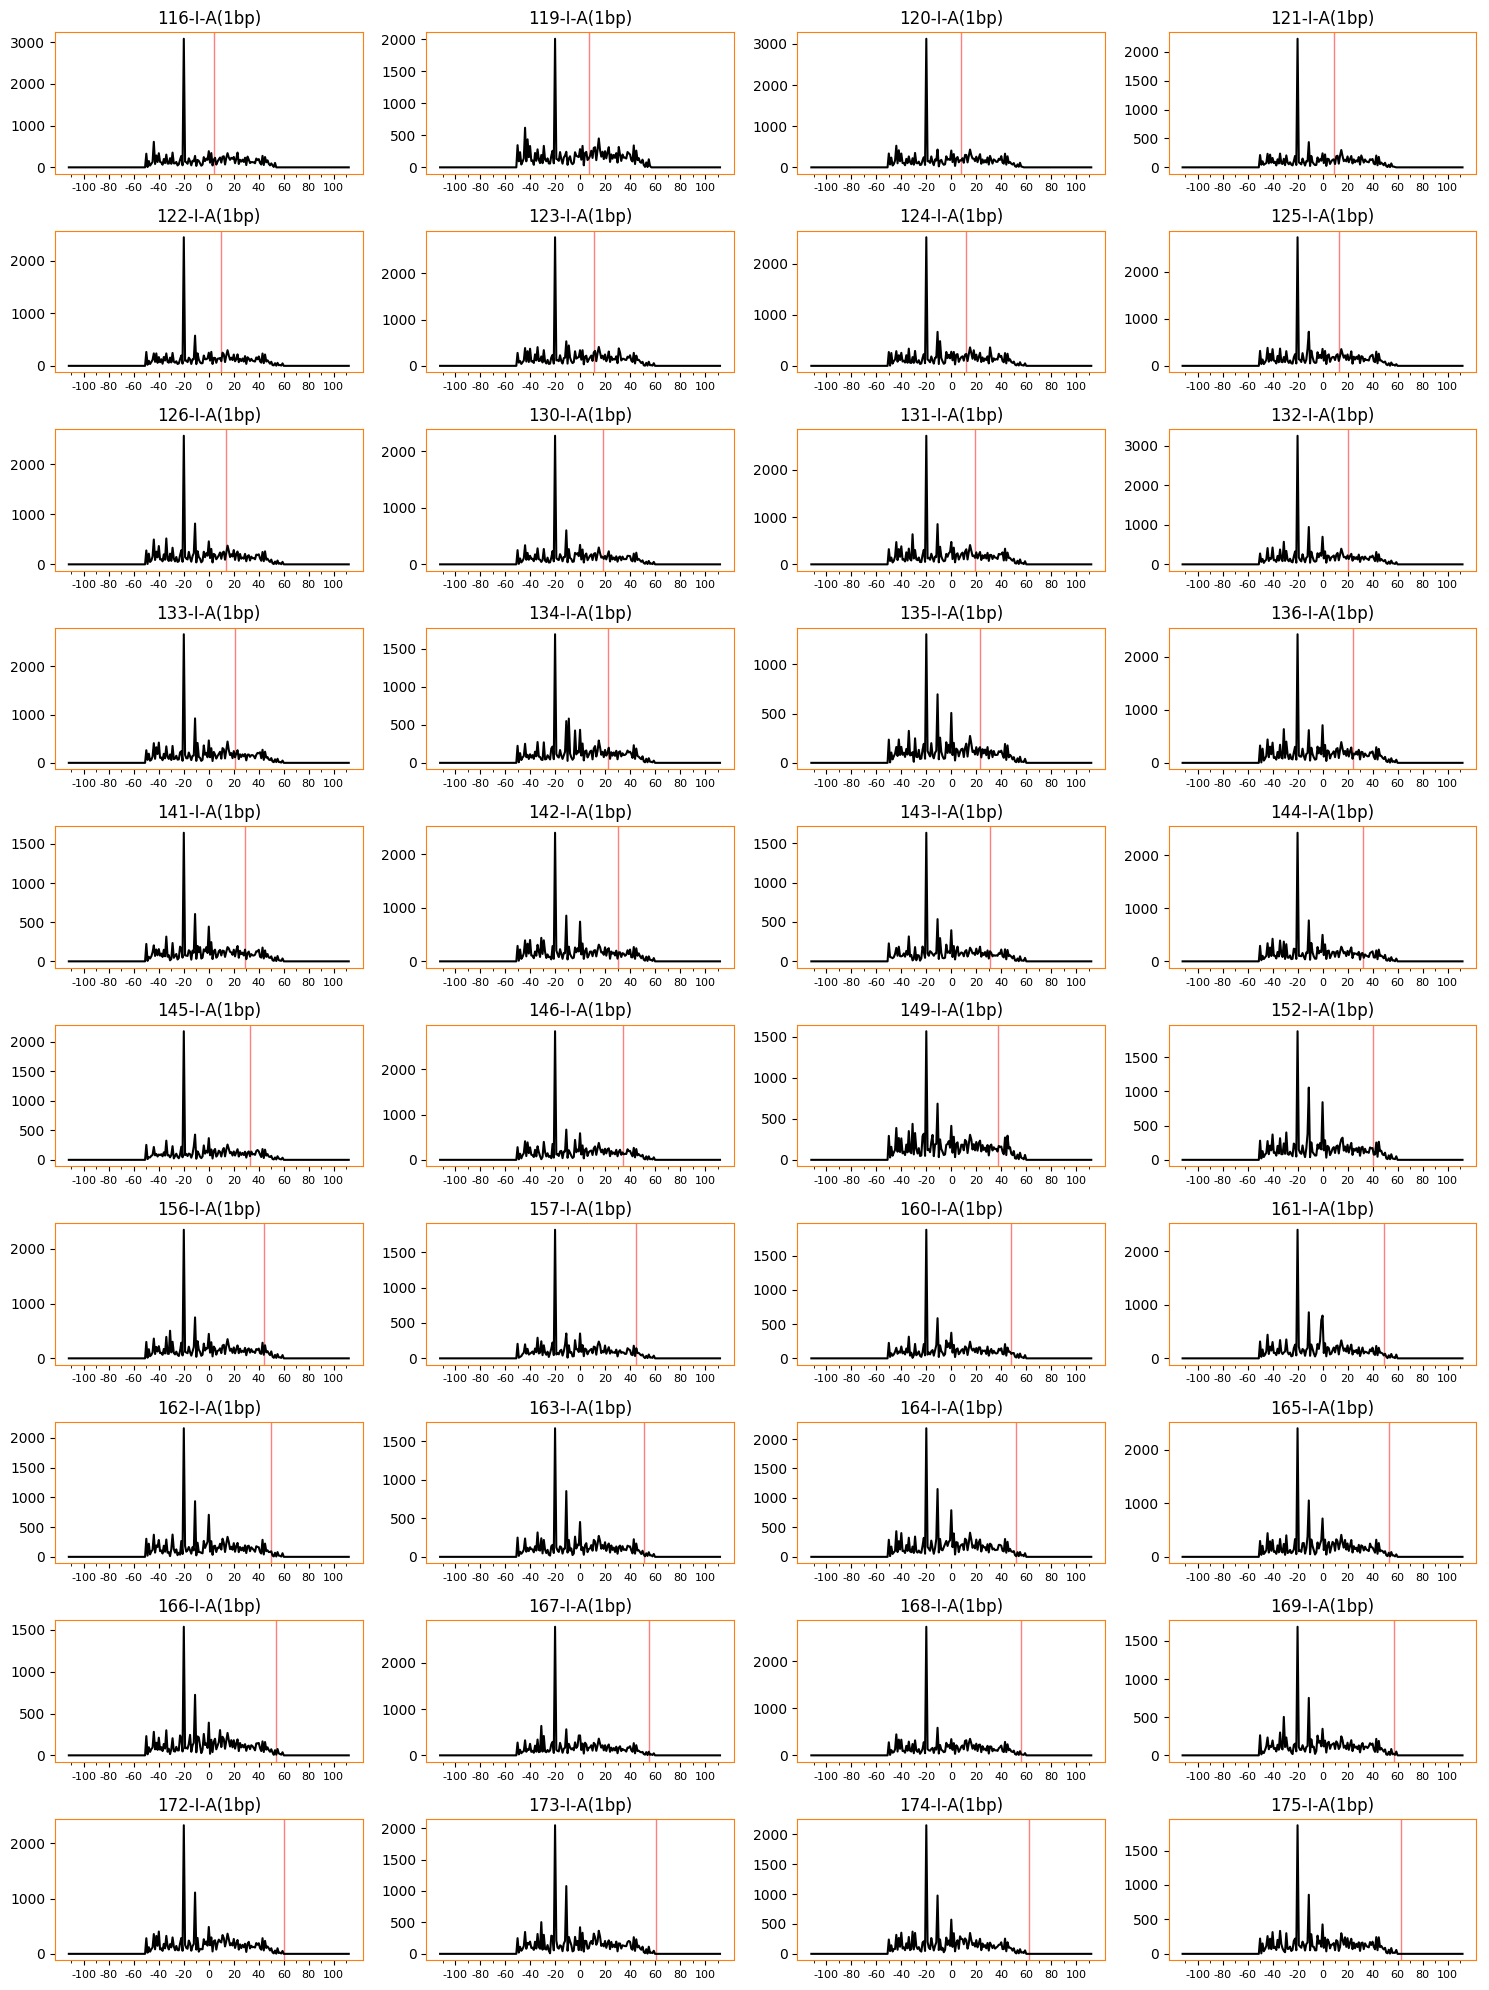


Cluster #3


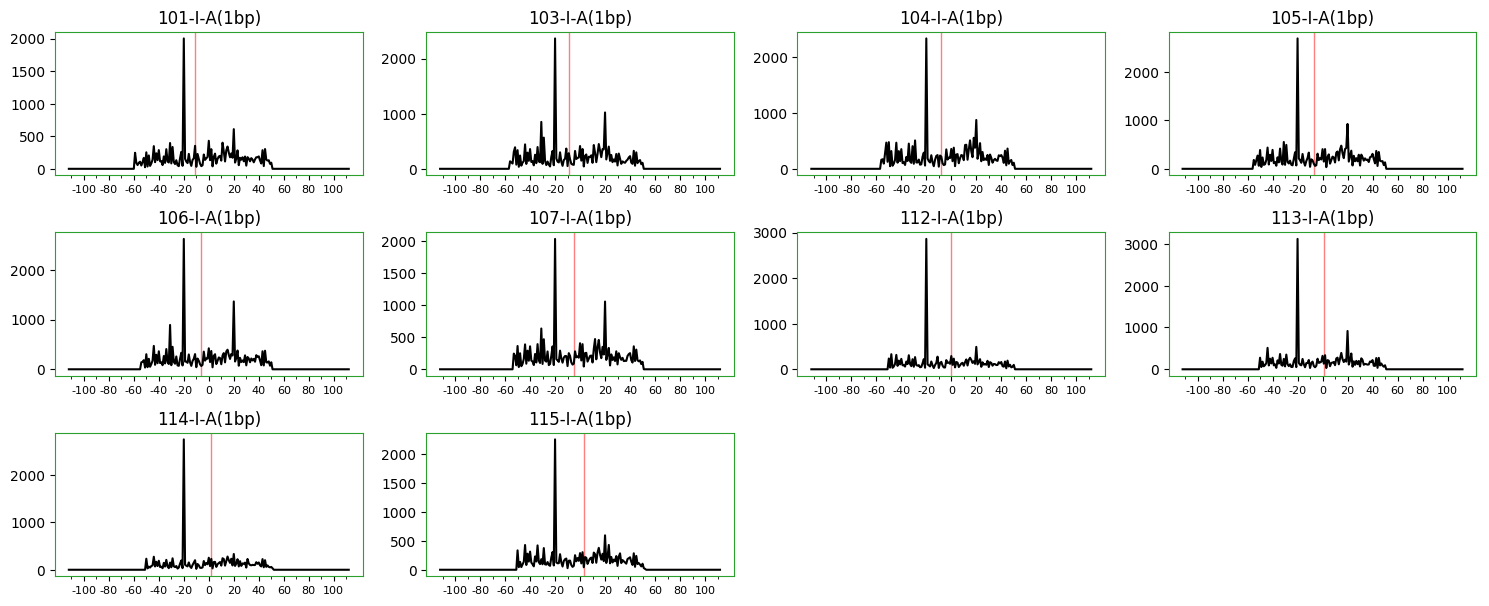


Cluster #4


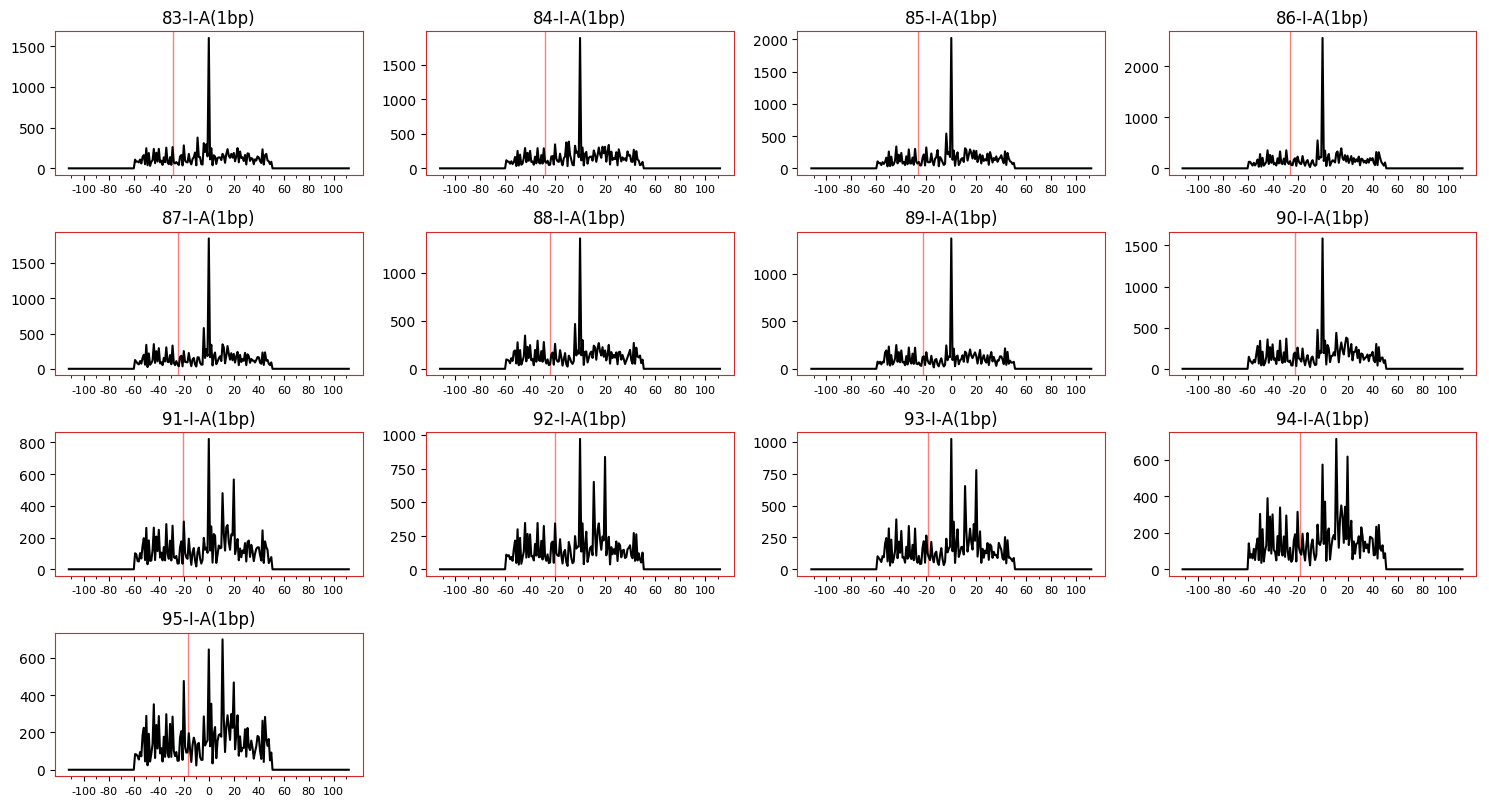

In [36]:
# plot positioning signals for each cluster (after)
for cID in sorted(cID_ids2.keys()):
    print
    print "Cluster #%d" % (cID+1)
    ids = sorted(cID_ids2[cID], cmp=analysis.wid_cmp_len)
    graph.plot_sig(insertion_sliders2, Slider.get_dyadmap, ids=ids, mark='wid', color='k', frame_color=color_list[cID],  xticks=[[i+tlen/2 for i in range(-100, 101, 20)], [str(i) for i in range(-100, 101, 20)]])

In [37]:
# plot clustering map
def plot_clustering_map(cID_ids, color_list):
    fig = plt.figure(figsize=(18,2))
    for cID in sorted(cID_ids.keys()):
        color = color_list[cID]
        X_list, Y_list = [], []
        for id in cID_ids[cID]:
            loc, mtype, nts = id.split('-')
            st = int(loc)
            X_list.append(st+1)
            Y_list.append(len(nts))
        plt.plot(X_list, Y_list, 'o', color=color, label='Cluster #' + str(cID+1))
    plt.title("Clustering map")
    plt.xlabel("Poly-A tract start position on 601 DNA")
    plt.ylabel('Size (bp)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

Before sliding


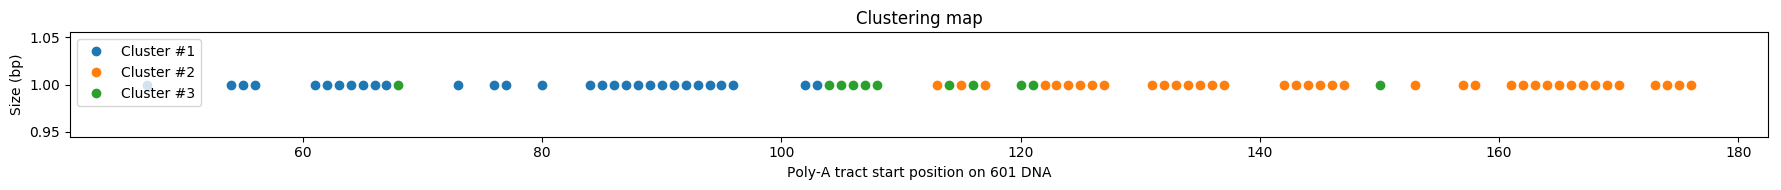

After sliding


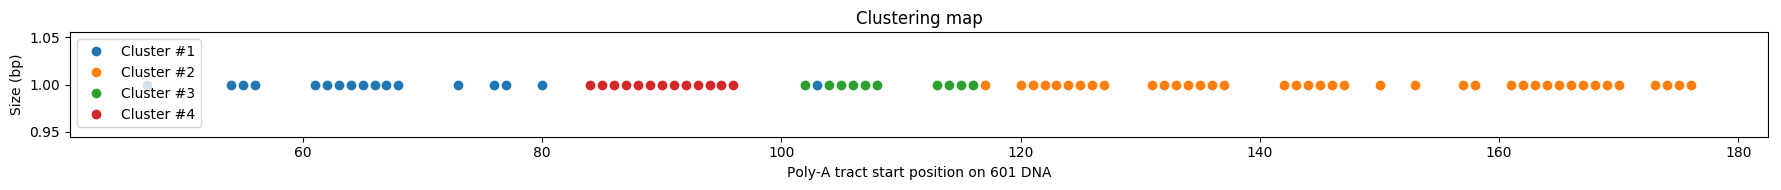

In [38]:
print "Before sliding"
plot_clustering_map(cID_ids1, color_list)
print "After sliding"
plot_clustering_map(cID_ids2, color_list)

In [39]:
# compute KL divergence
id_KL1, id_KL2 = {}, {}
for id in target_ids:
    KL1 = analysis.KL_div(id_psig1[id], WT_slider1.get_psig())
    KL2 = analysis.KL_div(id_psig2[id], WT_slider2.get_psig())
    id_KL1[id] = KL1
    id_KL2[id] = KL2

In [40]:
# plot KL divergence map
def plot_KLdiv_map (id_KL, id_cID):
    fig = plt.figure(figsize=(18,2))
    X_list, Y_list = [], []
    C_list = []
    for id in id_cID.keys():
        loc, mtype, nts = id.split('-')
        st = int(loc)
        KL = id_KL[id]
        X_list.append(st+1)
        Y_list.append(len(nts))
        C_list.append(KL)
    plt.scatter(X_list, Y_list, c=C_list, cmap = 'RdPu', vmin=min(id_KL.values()), vmax=max(id_KL.values()))
    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('KL-div', rotation=-90, va="bottom", labelpad=-1)
    plt.title("KL divergence map")
    plt.xlabel("insertion start position on 601 DNA")
    plt.ylabel('Size (bp)')
    plt.tight_layout()
    plt.show()
    plt.close()

Before slidng


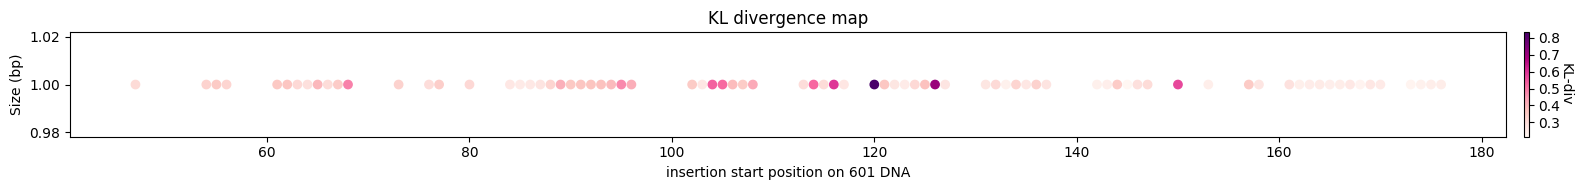

After slidng


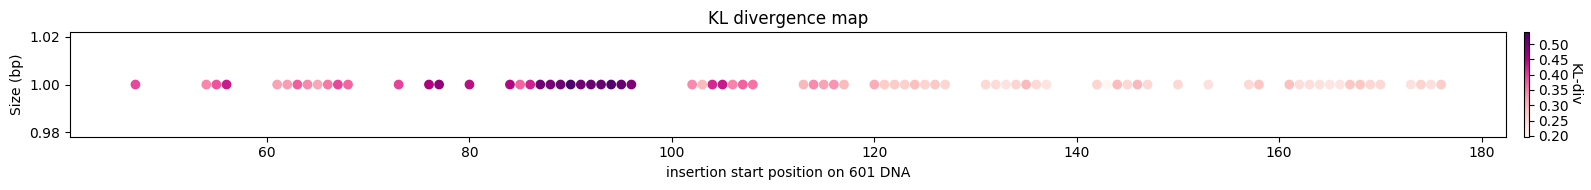

In [41]:
print "Before slidng"
plot_KLdiv_map (id_KL1, id_cID1)
print "After slidng"
plot_KLdiv_map (id_KL2, id_cID2)

In [42]:
# aggregate KL values according to size and location of perturbations
def aggregate_KL (id_KL):
    size_loc_KLs = {}
    for id in id_KL.keys():
        loc, mtype, nts = id.split('-')
        size = len(nts)
        if size not in size_loc_KLs:
            size_loc_KLs[size] = {}
        st = int(loc)
        ed = st+len(nts)
        for i in range(st, ed):
            if i not in size_loc_KLs[size]:
                size_loc_KLs[size][i] = []
            size_loc_KLs[size][i].append(id_KL[id])

    size_loc_meanKL = {}
    for size in size_loc_KLs:
        if size not in size_loc_meanKL:
            size_loc_meanKL[size] = {}
        for loc in size_loc_KLs[size]:
            meanKL = np.mean(size_loc_KLs[size][loc])
            size_loc_meanKL[size][loc] = meanKL

    return size_loc_meanKL

In [43]:
size_loc_meanKL1 = aggregate_KL (id_KL1)
size_loc_meanKL2 = aggregate_KL (id_KL2)

In [44]:
# plot aggreated KL-dv map
def plot_aggKL_map (size_loc_meanKL, id_cID, cmap='jet'):
    X_list, Y_list = [], []
    C_list, E_list = [], []
    for id, cID in id_cID.items():
        loc, mtype, nts = id.split('-')
        size = len(nts)
        st = int(loc)
        ed = st + size
        for k in range(st, ed):
            X_list.append(k+1)
            Y_list.append(size)
            C_list.append(size_loc_meanKL[size][k])
            E_list.append(color_list[cID])
    
    fig = plt.figure(figsize=(20,2))
    plt.scatter(X_list, Y_list, c=C_list, cmap = cmap, vmin=min(C_list), vmax=max(C_list))
    
    sizemin, sizemax = min(size_loc_meanKL.keys()), max(size_loc_meanKL.keys())
    plt.yticks(range(sizemin, sizemax+1, 1), [str(u)for u in range(sizemin, sizemax+1, 1)])
    plt.ylim([sizemin-0.5, sizemax+0.5])
    
    xticklabels = []
    label_count = 0
    TAs = []
    for pos in range(40, tlen-40):
        new_pos = pos - tlen/2
        if abs(new_pos) < 40 and (WTseq[pos:pos+2] == 'TA' or WTseq[pos-1:pos+1] == 'TA'):
            TAs.append(label_count)
        s = WTseq[pos]
        if abs(new_pos) % 10 == 0:
            s+= '\n'
            if new_pos > 0:
                s+= '+' + str(new_pos)
            else:
                s+= str(new_pos)
        xticklabels.append(s)
        label_count+=1
        
    plt.xticks(range(40, tlen-40), xticklabels)
    
    ax = plt.gca()
    for u in TAs:
        tl = ax.get_xticklabels()[u]
        tl.set_fontweight('bold')

    plt.xlim([40-0.5, tlen-41+0.5])
    
    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('KL-div', rotation=-90, va="bottom", labelpad=-1)
    plt.title("Perturbation map")
    plt.xlabel("Poly-A tract locations on 601 DNA")
    plt.ylabel('Size (bp)')
    plt.tight_layout()
    plt.show()
    plt.close()

In [45]:
# plot aggreated cluster map
def plot_aggcluster_map (cID_ids):
    fig = plt.figure(figsize=(18,2))
    for cID in sorted(cID_ids.keys()):
        color = color_list[cID]
        X_list, Y_list = [], []
        for id in cID_ids[cID]:
            loc, mtype, nts = id.split('-')
            size = len(nts)
            st = int(loc)
            ed = st + size
            for k in range(st, ed):
                X_list.append(k+1)
                Y_list.append(size)
        plt.plot(X_list, Y_list, 'o', color=color, label='Cluster #' + str(cID+1))
    
    xticklabels = []
    label_count = 0
    TAs = []
    for pos in range(40, tlen-40):
        new_pos = pos - tlen/2
        if abs(new_pos) < 40 and (WTseq[pos:pos+2] == 'TA' or WTseq[pos-1:pos+1] == 'TA'):
            TAs.append(label_count)
        s = WTseq[pos]
        if abs(new_pos) % 10 == 0:
            s+= '\n'
            if new_pos > 0:
                s+= '+' + str(new_pos)
            else:
                s+= str(new_pos)
        xticklabels.append(s)
        label_count+=1
        
    plt.xticks(range(40, tlen-40), xticklabels)
    
    ax = plt.gca()
    for u in TAs:
        tl = ax.get_xticklabels()[u]
        tl.set_fontweight('bold')

    plt.xlim([40-0.5, tlen-41+0.5])
    
    plt.yticks(range(1,2), [str(u) for u in range(1,2)])
    plt.ylim([1-0.5, 1+0.5])
    
    plt.title("Clustering map")
    plt.xlabel("Poly-A tract locations on 601 DNA")
    plt.ylabel('Size (bp)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

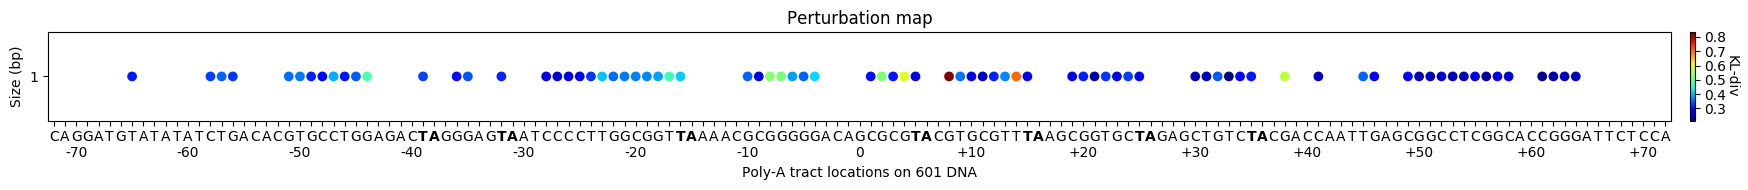

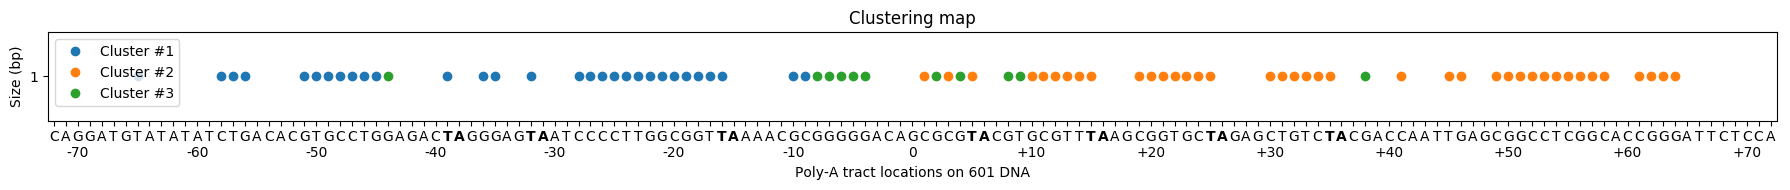

In [46]:
# before sliding
plot_aggKL_map (size_loc_meanKL1, id_cID1)
plot_aggcluster_map (cID_ids1)

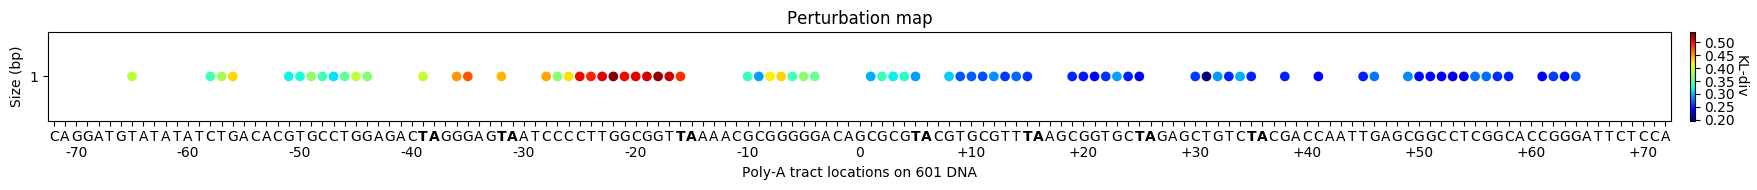

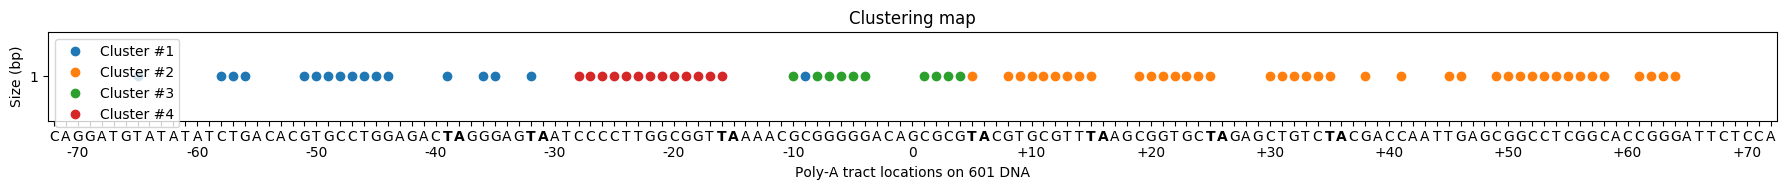

In [47]:
# after sliding
plot_aggKL_map (size_loc_meanKL2, id_cID2)
plot_aggcluster_map (cID_ids2)

In [48]:
# plot the perturbation map with signal
def mean_signal_plot (id_sig, 
                      control_sig,
                      ids = [], 
                      color=None):
    
    if len(ids) <= 0:
        ids = sorted(id_sig.keys(), cmp=analysis.wid_cmp_len)
    
    sig_list = []
    X, Y = [], []
    for id in ids:
        sig_list.append(id_sig[id])
        loc, mtype, nts = id.split('-')
        st = int(loc)
        ed = st+len(nts)
        for k in range(st, ed):
            X.append(k+1)
            Y.append(len(nts))
    
    mean_sig = np.mean(sig_list, axis=0)
    error_sig = np.std(sig_list, axis=0)
    
    fig = plt.figure(figsize=(20,3))
    #fig = plt.figure()
    
    #plt.plot(control_sig, 'k--', linewidth=2)
    plt.plot(mean_sig, color=color, linewidth=10)
    #plt.fill_between(range(len(mean_sig)), mean_sig-error_sig, mean_sig+error_sig, color=color, alpha=0.5)
    
    xticklabels = []
    label_count = 0
    TAs = []
    for pos in range(40, tlen-40):
        new_pos = pos - tlen/2
        if abs(new_pos) < 40 and (WTseq[pos:pos+2] == 'TA' or WTseq[pos-1:pos+1] == 'TA'):
            TAs.append(label_count)
        s = WTseq[pos]
        if abs(new_pos) % 10 == 0:
            s+= '\n'
            if new_pos > 0:
                s+= '+' + str(new_pos)
            else:
                s+= str(new_pos)
        xticklabels.append(s)
        label_count+=1
        
    #plt.xticks(range(40, tlen-40), xticklabels)
    
    #for u in TAs:
    #    tl = plt.gca().get_xticklabels()[u]
    #    tl.set_fontweight('bold')

    #plt.xlim([40-0.5, tlen-41+0.5])
      
    fig.tight_layout()
    plt.show()
    plt.close()


Cluster #1


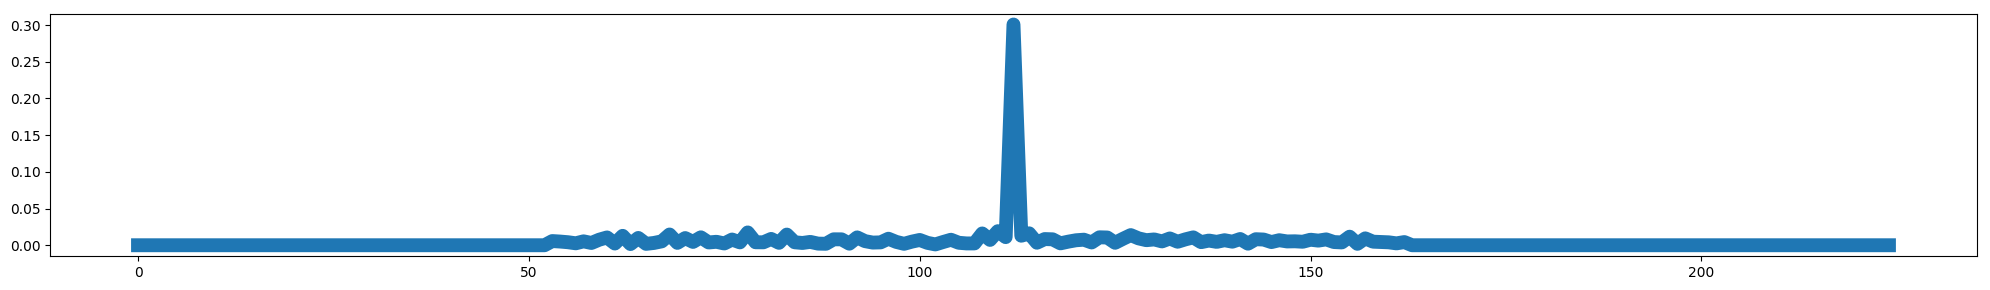


Cluster #2


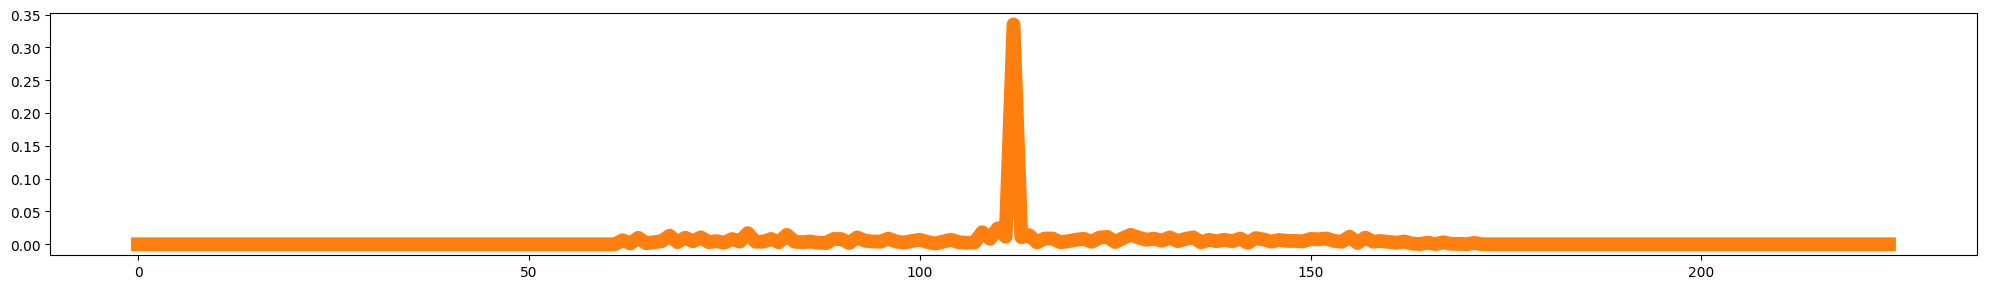


Cluster #3


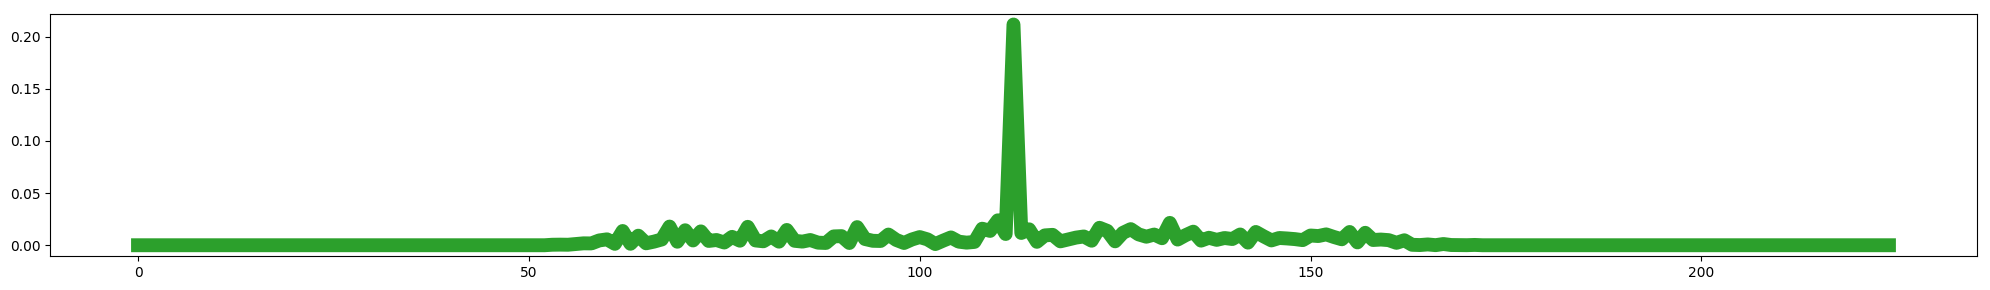

In [49]:
# plot positioning signals for each cluster (before)
for cID in sorted(cID_ids1.keys()):
    print
    print "Cluster #%d" % (cID+1)
    ids = sorted(cID_ids1[cID], cmp=analysis.wid_cmp_len)
    mean_signal_plot (id_psig1,
                      WT_slider1.get_psig(),
                      ids = ids,
                      color=color_list[cID])


Cluster #1


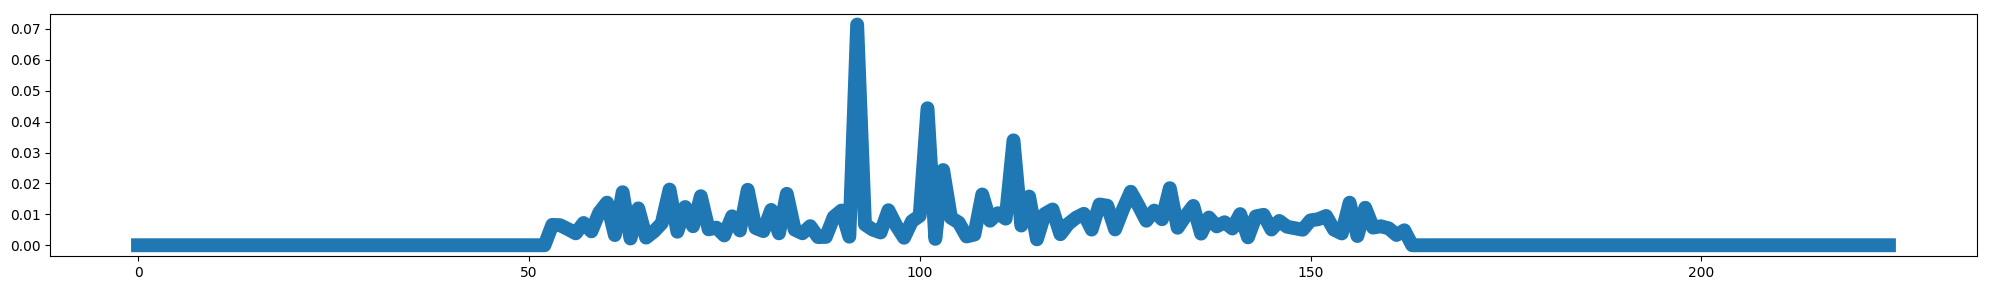


Cluster #2


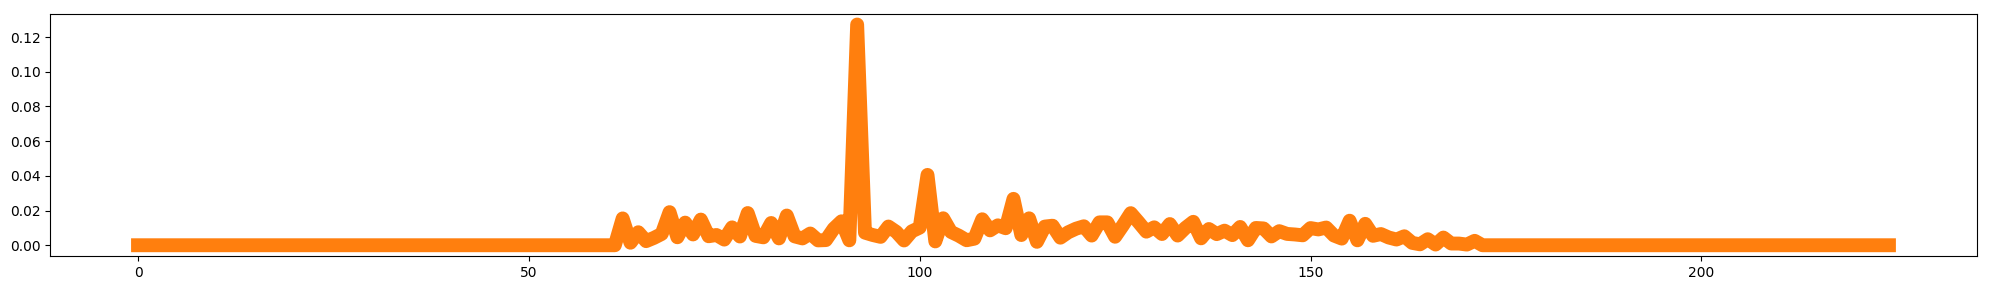


Cluster #3


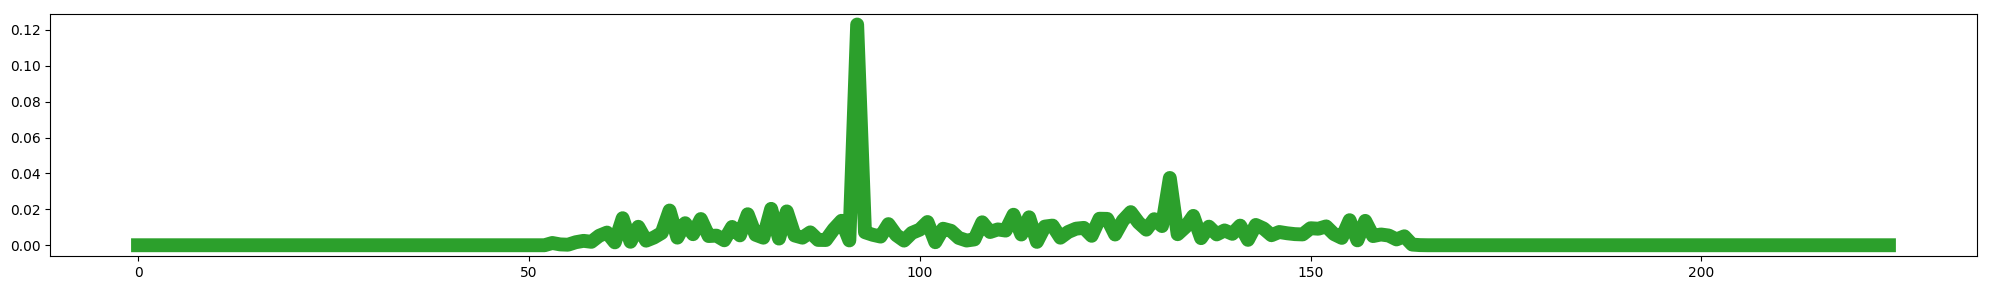


Cluster #4


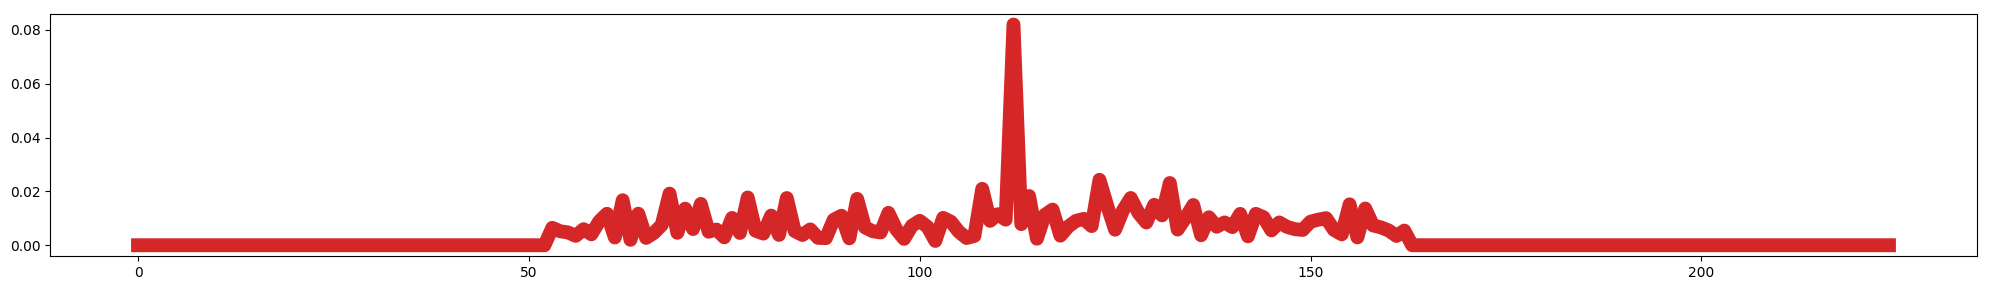

In [50]:
# plot positioning signals for each cluster (After)
for cID in sorted(cID_ids2.keys()):
    print
    print "Cluster #%d" % (cID+1)
    ids = sorted(cID_ids2[cID], cmp=analysis.wid_cmp_len)
    mean_signal_plot (id_psig2,
                      WT_slider2.get_psig(),
                      ids=ids,
                      color=color_list[cID])

In [51]:
# plot the perturbation map with signal
def plot_perturbation_signal_map (id_sig, 
                                  control_sig, 
                                  size_loc_meanKL,
                                  ids = [],
                                  ylims=None, 
                                  clims=None, 
                                  color=None,
                                  cmap='jet'):
    
    if len(ids) <= 0:
        ids = analysis.sorted(id_sig.keys(), cmp=analysis.wid_cmp_len)
    
    min_size, max_size = min(size_loc_meanKL.keys()), max(size_loc_meanKL.keys())
    
    meanKLs = []
    for size in size_loc_meanKL:
        for loc in size_loc_meanKL[size]:
            meanKL = size_loc_meanKL[size][loc]
            meanKLs.append(meanKL)
    min_KL, max_KL = min(meanKLs), max(meanKLs)
    
    if not ylims:
        ylims = [min_size, max_size]
    if not clims:
        clims = [min_KL, max_KL]
    
    sig_list = []
    X, Y, C = [], [], []
    for id in ids:
        sig_list.append(id_sig[id])
        loc, mtype, nts = id.split('-')
        st = int(loc)
        ed = st+len(nts)
        for k in range(st, ed):
            X.append(k+1)
            Y.append(len(nts))
            C.append(size_loc_meanKL[len(nts)][k])
    
    mean_sig = np.mean(sig_list, axis=0)
    error_sig = np.std(sig_list, axis=0)
    
    fig = plt.figure(figsize=(20,3))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    ax2.plot(control_sig, 'k--', linewidth=2)
    ax2.plot(mean_sig, color=color, linewidth=2)
    ax2.fill_between(range(len(mean_sig)), mean_sig-error_sig, mean_sig+error_sig, color=color, alpha=0.5)
    
    ax = ax1.scatter(X, Y, c=C, vmin=min_KL, vmax=max_KL, cmap=cmap, alpha=1)
    
    xticklabels = []
    label_count = 0
    TAs = []
    for pos in range(40, tlen-40):
        new_pos = pos - tlen/2
        if abs(new_pos) < 40 and (WTseq[pos:pos+2] == 'TA' or WTseq[pos-1:pos+1] == 'TA'):
            TAs.append(label_count)
        s = WTseq[pos]
        if abs(new_pos) % 10 == 0:
            s+= '\n'
            if new_pos > 0:
                s+= '+' + str(new_pos)
            else:
                s+= str(new_pos)
        xticklabels.append(s)
        label_count+=1
        
    ax1.set_xticks(range(40, tlen-40))
    ax1.set_xticklabels(xticklabels)
    
    for u in TAs:
        tl = ax1.get_xticklabels()[u]
        tl.set_fontweight('bold')

    ax1.set_xlim([40-0.5, tlen-41+0.5])
      
    ax1.set_ylim([ylims[0]-1.5, ylims[1]+0.5])
    ax1.set_yticks(range(ylims[0], ylims[1]+1, 1))
    ax1.set_yticklabels([str(u)for u in range(ylims[0], ylims[1]+1, 1)])
    ax1.set_ylabel('Size (bp)')
    
    cbar = plt.colorbar(ax)
    cbar.ax.set_ylabel('KL-div', rotation=-90, va="bottom")
    fig.tight_layout()
    plt.show()
    plt.close()


Cluster #1


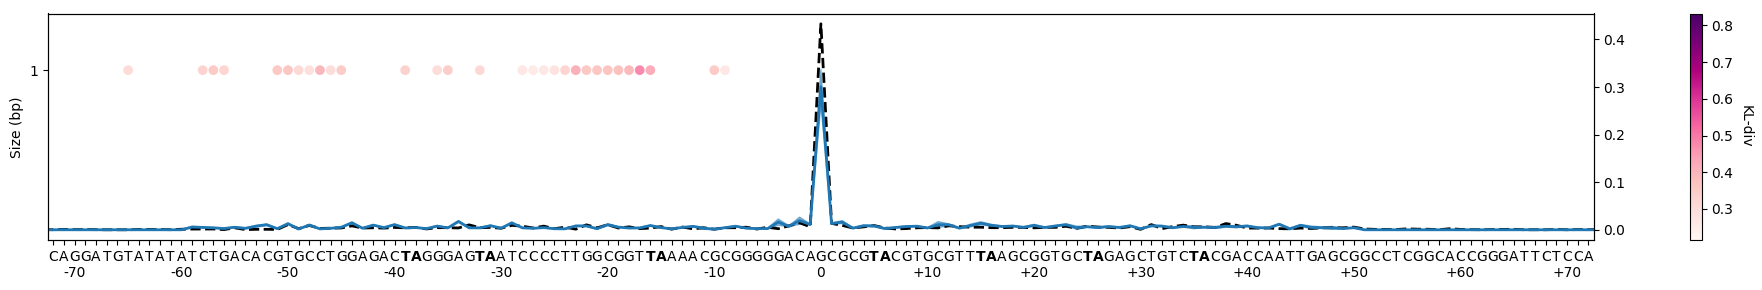


Cluster #2


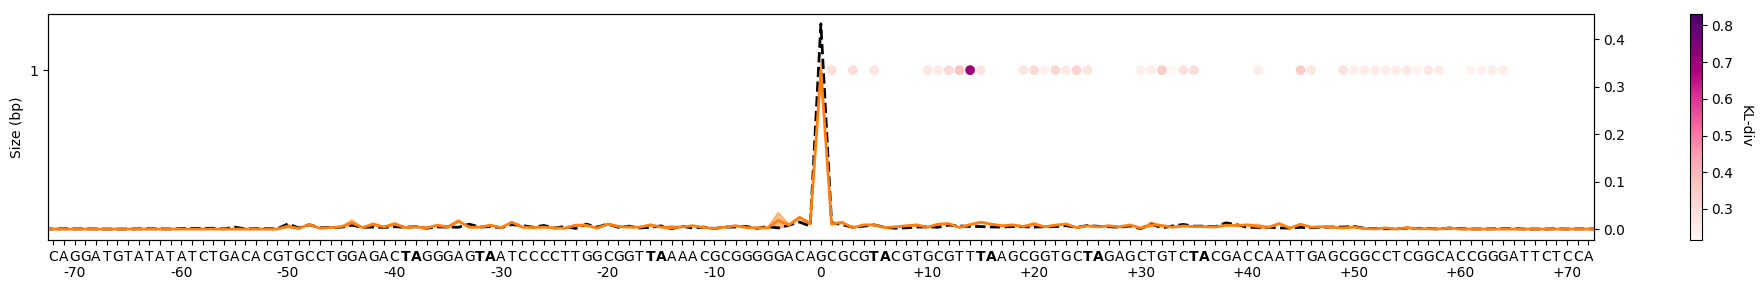


Cluster #3


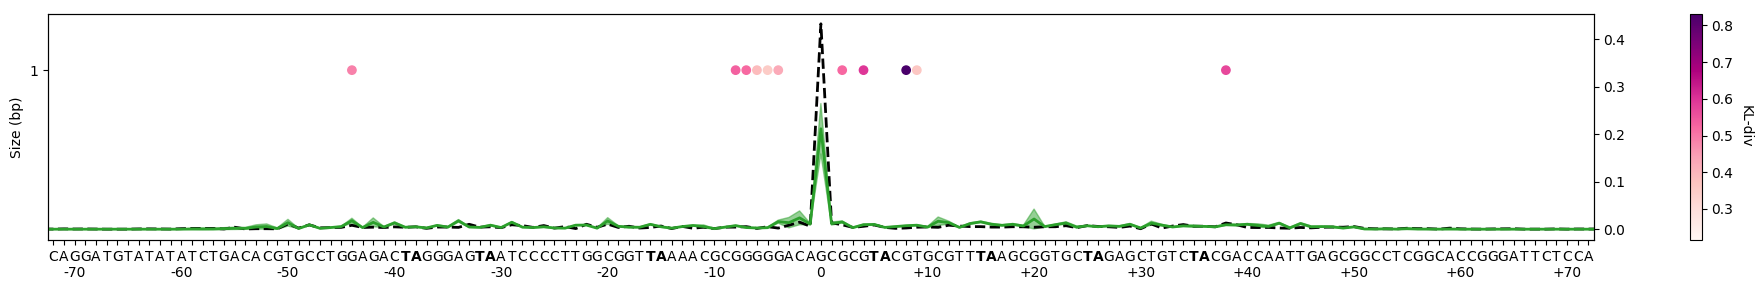

In [52]:
# plot positioning signals for each cluster (before)
for cID in sorted(cID_ids1.keys()):
    print
    print "Cluster #%d" % (cID+1)
    ids = sorted(cID_ids1[cID], cmp=analysis.wid_cmp_len)
    plot_perturbation_signal_map(id_psig1,
                                 WT_slider1.get_psig(),
                                 size_loc_meanKL1,
                                 ids=ids, 
                                 color=color_list[cID],
                                 cmap='RdPu')


Cluster #1


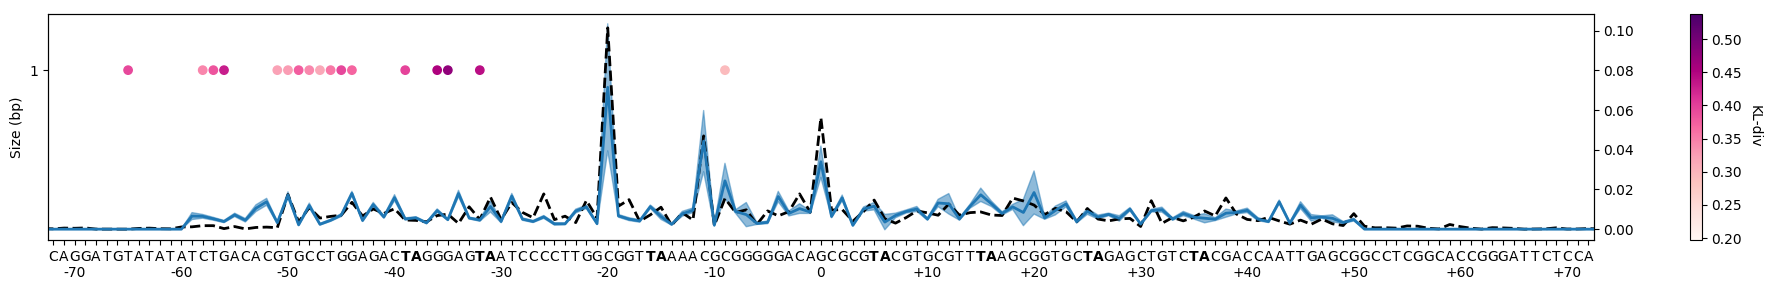


Cluster #2


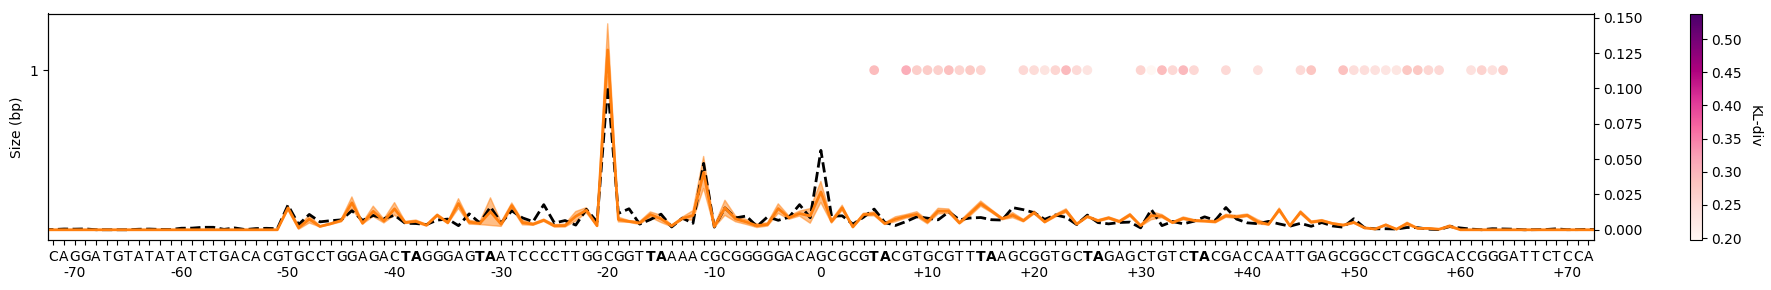


Cluster #3


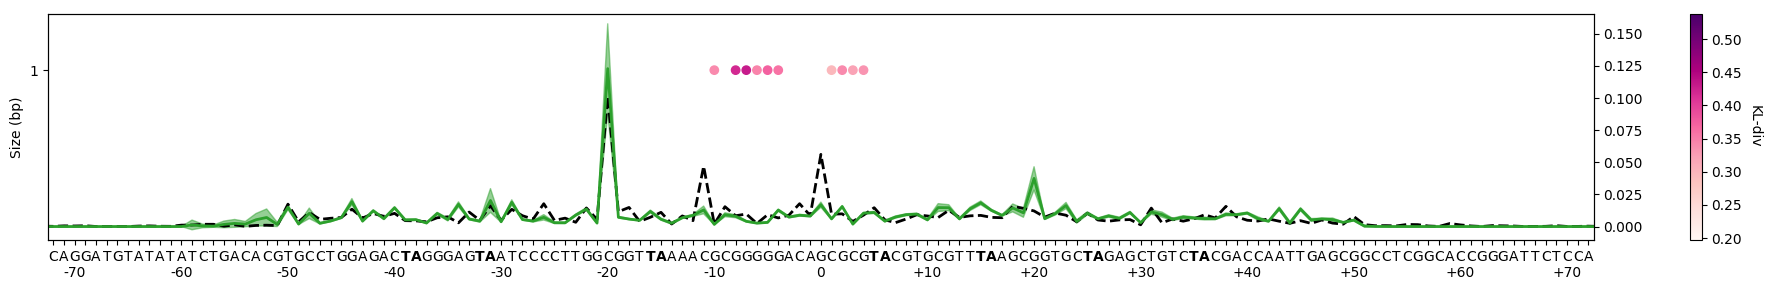


Cluster #4


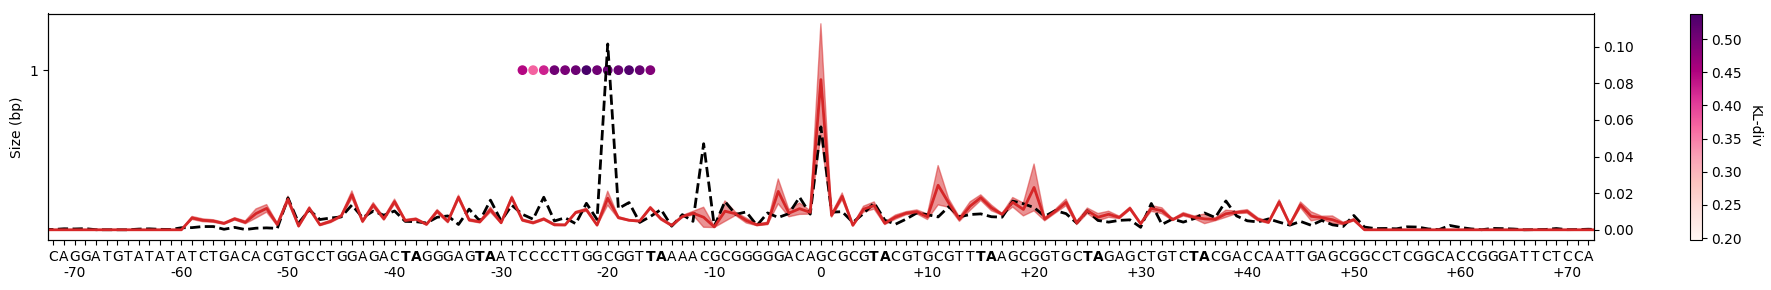

In [53]:
# plot positioning signals for each cluster (after)
for cID in sorted(cID_ids2.keys()):
    print
    print "Cluster #%d" % (cID+1)
    ids = sorted(cID_ids2[cID], cmp=analysis.wid_cmp_len)
    plot_perturbation_signal_map(id_psig2,
                                 WT_slider2.get_psig(),
                                 size_loc_meanKL2,
                                 ids=ids, 
                                 color=color_list[cID],
                                 cmap='RdPu')